# Module 11: Machine Learning using SparkML

Artificial Intelligence and Machine Learning have made a comeback in the last few years due to the ubiquity of inexpensive, fast computational platforms and advancements in algorithm designs.

In this session, we will discuss the usage of Apache Spark in executing distributed parallel machine learning processes to achieve artificial intelligence.

- https://spark.apache.org/docs/latest/ml-guide.html

In this notebook, we will take on the [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/code?competitionId=6960)  Kaggle competition.

Make sure to review the setup instructions on Module11.pdf.

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf, col, lit, hour, count
from pyspark.sql.types import DoubleType

In [3]:
plt.style.use('dark_background')

### Create a spark instance.

In [4]:
mkl_installed = True

if mkl_installed:
    extraJavaOptions = " ".join([
        "-Dcom.github.fommil.netlib.BLAS=com.intel.mkl.MKLBLAS",
        "-Dcom.github.fommil.netlib.LAPACK=com.intel.mkl.MKLLAPACK"
    ])
    extraClassPath = "/opt/intel/mkl/wrapper/mkl_wrapper.jar"
else:
    extraJavaOptions=""
    extraClassPath=""

In [5]:
spark = SparkSession\
    .builder\
    .master("local[*]")\
    .config("spark.driver.memory","31G")\
    .config("spark.executor.memory","31G")\
    .config("spark.ui.enabled",False)\
    .config("spark.sql.catalogImplementation","in-memory")\
    .config("spark.serializer","org.apache.spark.serializer.KryoSerializer")\
    .config("spark.driver.extraJavaOptions",f"{extraJavaOptions}")\
    .config("spark.driver.extraClassPath",f"{extraClassPath}")\
    .config("spark.executor.extraJavaOptions",f"{extraJavaOptions}")\
    .config("spark.executor.extraClassPath",f"{extraClassPath}")\
    .config("spark.executor.MKL_VERBOSE",1)\
    .getOrCreate()

24/11/16 08:22:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Explicit schema definition that can be composed from the first line of train.csv file.

Note the backtick (`) before and after the name, just in the case the name in the head has a space in it. the backtick will encapsulate it :-)

In [6]:
schema = ",".join([
"`id` string",
"`vendor_id` string",
"`pickup_datetime` timestamp",
"`dropoff_datetime` timestamp",
"`passenger_count` integer",
"`pickup_longitude` double",
"`pickup_latitude` double",
"`dropoff_longitude` double",
"`dropoff_latitude` double",
"`store_and_fwd_flag` string",
"`trip_duration` integer" # seconds
])

### Read CSV data and rename and drop some columns

In [7]:
csv_path = "train.csv"

trips = spark\
    .read\
    .csv(csv_path, schema=schema, sep=",", mode="DROPMALFORMED")\
    .withColumnRenamed("pickup_datetime", "p_date")\
    .withColumnRenamed("pickup_longitude", "p_lon")\
    .withColumnRenamed("pickup_latitude", "p_lat")\
    .withColumnRenamed("dropoff_datetime", "d_date")\
    .withColumnRenamed("dropoff_longitude", "d_lon")\
    .withColumnRenamed("dropoff_latitude", "d_lat")\
    .withColumnRenamed("trip_duration", "duration")\
    .drop("id")\
    .drop("vendor_id")\
    .drop("passenger_count")\
    .drop("store_and_fwd_flag")

trips.createOrReplaceTempView("trips")

### Define spatial extent and filter data about Manhattan, JFK and Laguardia.

Note: You can use a tool like [this](https://davidspriggs.github.io/js-extent-helper/extentHelper) to help you find the extent :-)

![](./Map.png)

In [8]:
xmin,ymin,xmax,ymax = [-74.04226680414989,40.6059735081628,-73.5061146385722,40.91340235669589]

### Define a where clause to apply and filter the data.

In [9]:
where = " and ".join([
    f"p_lon between {xmin} and {xmax}",
    f"p_lat between {ymin} and {ymax}",
    f"d_lon between {xmin} and {xmax}",
    f"d_lat between {ymin} and {ymax}"    
])

df = trips.where(where).cache()

### Let's look at the pickup and dropoff hour distribution.

As we believe hour of day is an important factor in duration calculation.

Note the `toPandas()` at the end to bring the data back to the driver/notebook server in such that we can plot the result.

In [10]:
data = df\
    .select(hour(col("p_date")).alias("hh"))\
    .groupBy("hh")\
    .agg(count("hh").alias("counts"))\
    .orderBy("hh")\
    .toPandas()

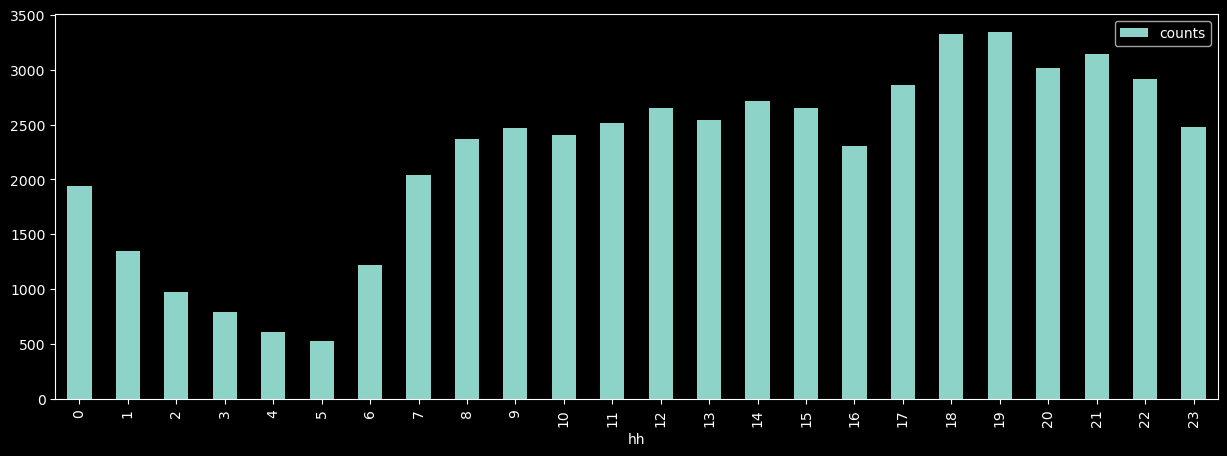

In [11]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data.plot.bar(x="hh", y="counts", ax=ax)
plt.show()

In [12]:
data = df\
    .select(hour(col("d_date")).alias("hh"))\
    .groupBy("hh")\
    .agg(count("hh").alias("counts"))\
    .orderBy("hh")\
    .toPandas()

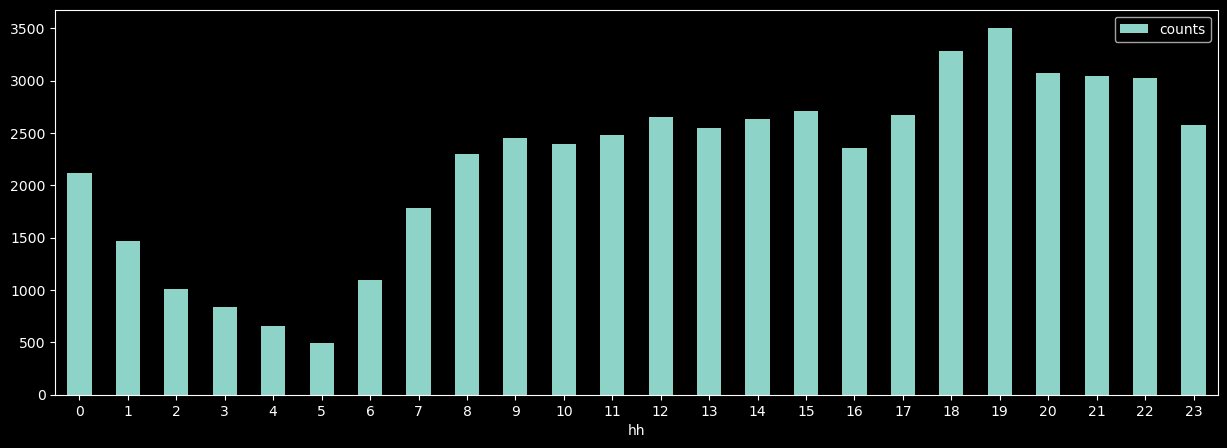

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
data.plot.bar(x="hh", y="counts", ax=ax, rot=0)
plt.show()

### Define UDF to calculate geodesic haversine distance between 2 points.

Review [pyspark.sql.functions.pandas_udf](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.pandas_udf.html).

In [14]:
def haversine_(lat1:pd.Series, lon1:pd.Series, lat2:pd.Series, lon2:pd.Series) -> pd.Series:
    EARTH_RADIUS_M = 6378137.0  # Meters
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dy = np.sin((lat2 - lat1) * 0.5)
    dx = np.sin((lon2 - lon1) * 0.5)
    a = dy * dy + np.cos(lat1) * np.cos(lat2) * dx * dx
    c = 2.0 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_M * c


@pandas_udf(DoubleType())
def haversine(lat1:pd.Series, lon1:pd.Series, lat2:pd.Series, lon2:pd.Series) -> pd.Series:
    return haversine_(lat1, lon1, lat2, lon2)

### Get max duration based on geodesic Manhattan distance of extent assuming 45 mph average

In [15]:
lon1 = pd.Series([xmin,xmax])
lat1 = pd.Series([ymin,ymin])

lon2 = pd.Series([xmax,xmax])
lat2 = pd.Series([ymin,ymax])

mps = 20.0 # ~ 45 mph
max_duration_in_sec = np.sum(haversine_(lat1,lon1,lat2,lon2)) / mps
max_duration_in_sec

3976.7596558633086

### Get duration values description (statistics)

In [16]:
duration = df.select("duration")
duration.describe().show()

+-------+-----------------+
|summary|         duration|
+-------+-----------------+
|  count|            53161|
|   mean|940.9532740166663|
| stddev|3121.992421759897|
|    min|                1|
|    max|            86357|
+-------+-----------------+



### Let's see the distribution of the duration data for further filter.

- [RDD.histogram](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.histogram.html)
- Note that we are converting DF to RDD to use histogram action.

In [17]:
min_duration_in_sec = 60
where = f"duration between {min_duration_in_sec} and {max_duration_in_sec}"

bins,data = duration\
    .where(where)\
    .rdd\
    .flatMap(lambda _:_)\
    .histogram(250)

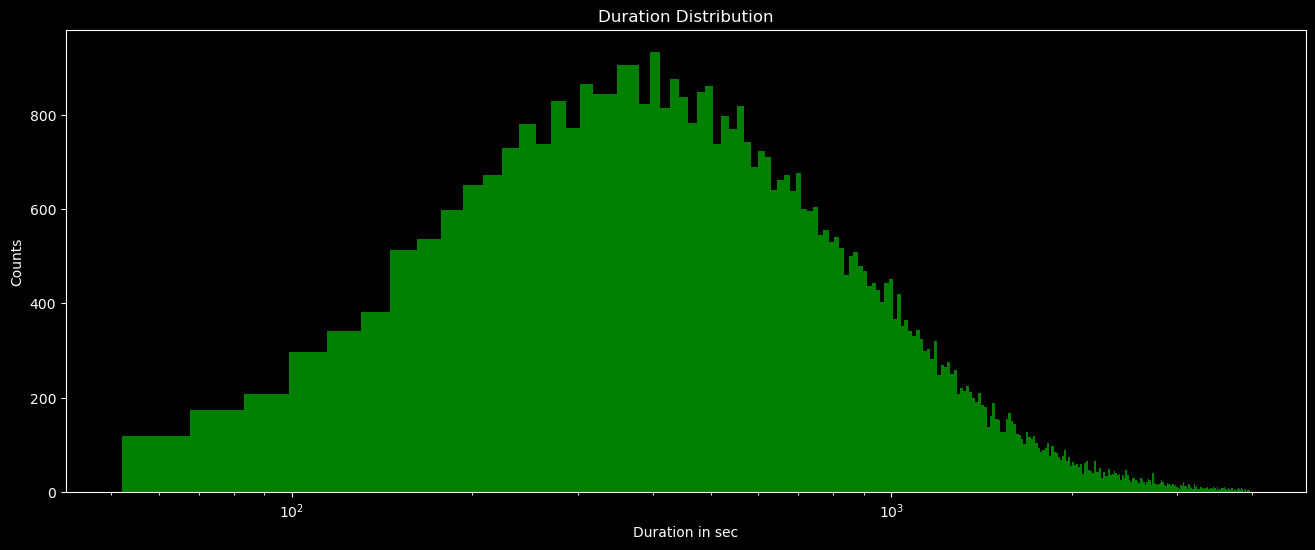

In [18]:
mids = bins[:-1]
widths = [abs(l - r) for l, r in zip(bins[:-1], bins[1:])]

plt.figure(figsize=(16,6))
plt.xlabel("Duration in sec")
plt.ylabel("Counts")
plt.title("Duration Distribution")
plt.xscale('log')  # Uncomment this to see the log.
plt.bar(mids, data, width=widths, color='g')
plt.show()

### Let's put the data together now.

- Restrict duration between 1 min to 90 minutes.
- Map hour of day to fraction of pi for "circular" mapping.
- Create label (value to be predicted) as log10 of original value.

In [19]:
to_pi = math.pi / 23.0

df2 = df\
    .where("duration between 60 and 5400")\
    .select("p_lon",
            "p_lat",
            "d_lon",
            "d_lat",
            (F.hour(col("p_date"))*to_pi).alias("pi"),
            F.log10(col("duration")).alias("label"))\
    .withColumn("hh_cos", F.cos(col("pi")))\
    .withColumn("hh_sin", F.sin(col("pi")))\
    .drop("pi")

### Create training vector

In [20]:
assembler = VectorAssembler(
    inputCols=["p_lon","p_lat","d_lon","d_lat","hh_cos","hh_sin"],
    outputCol="features")

df3 = assembler.transform(df2)

In [21]:
df3.printSchema()

root
 |-- p_lon: double (nullable = true)
 |-- p_lat: double (nullable = true)
 |-- d_lon: double (nullable = true)
 |-- d_lat: double (nullable = true)
 |-- label: double (nullable = true)
 |-- hh_cos: double (nullable = true)
 |-- hh_sin: double (nullable = true)
 |-- features: vector (nullable = true)



### Split the data into training and validation set.

- The model will train on the training data.
- The model KPI will be calculated off unseen data (the validation data).

In [22]:
train,valid = df3.select("features","label").randomSplit([0.7, 0.3])

### Fit Generalized Linear Regression Model

- https://spark.apache.org/docs/latest/ml-classification-regression.html#generalized-linear-regression

In [23]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(family="gaussian",
                                  link="identity",
                                  maxIter=100,
                                  regParam=0.3)

In [24]:
model = glr.fit(train)

24/11/16 08:29:49 WARN BLAS: Failed to load implementation from: com.intel.mkl.MKLBLAS
24/11/16 08:29:49 WARN BLAS: Using the fallback implementation.
24/11/16 08:29:49 WARN LAPACK: Failed to load implementation from: com.intel.mkl.MKLLAPACK
24/11/16 08:29:49 WARN LAPACK: Using the fallback implementation.


### Model summary explanations:

- https://www.youtube.com/watch?v=8vHVV_TH570
- https://www.youtube.com/watch?v=lJJJ50dMJKM
- https://databricks.com/session_na20/model-explanation-and-prediction-exploration-using-spark-ml

In [25]:
model.summary

Coefficients:
    Feature Estimate Std Error  T Value P Value
(Intercept) 202.2033    3.7560  53.8342  0.0000
      p_lon   0.8601    0.0305  28.2320  0.0000
      p_lat  -0.9452    0.0417 -22.6676  0.0000
      d_lon   0.9261    0.0336  27.5799  0.0000
      d_lat  -0.7060    0.0367 -19.2273  0.0000
     hh_cos  -0.0162    0.0017  -9.5187  0.0000
     hh_sin   0.0335    0.0034   9.8904  0.0000

(Dispersion parameter for gaussian family taken to be 0.0898)
    Null deviance: 3693.7850 on 36834 degrees of freedom
Residual deviance: 3306.3492 on 36834 degrees of freedom
AIC: 15751.1718

### Let evaluate the model by transforming the validation data.

In [26]:
pred = model.transform(valid)

In [27]:
pred.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- prediction: double (nullable = false)



In [28]:
pred.select("prediction","label","features").show()

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
|2.8105185862027895|2.8109042806687006|[-74.017669677734...|
|2.8986022814532078| 3.256477206241677|[-74.017341613769...|
| 2.859987434159649|3.0622058088197126|[-74.017219543457...|
|2.8000567455689804| 3.274619619091238|[-74.017211914062...|
|2.8103120902669616| 2.767897616018091|[-74.017166137695...|
|2.8074125390507163|3.0330214446829107|[-74.017150878906...|
| 2.819999832988003| 2.401400540781544|[-74.017097473144...|
| 2.819932110467164| 2.519827993775719|[-74.017059326171...|
|2.8149825854677886|2.5998830720736876|[-74.016876220703...|
|2.7754829771085667|2.8609366207000937|[-74.016853332519...|
|2.8085192573587676|  2.75815462196739|[-74.016807556152...|
| 2.809201816670452| 3.299942900022767|[-74.016738891601...|
|2.8233599865075973| 2.888179493918325|[-74.016708374023...|
|  2.78608379699682|2.95

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(pred)

f"Root Mean Squared Error (RMSE) on validation data = {rmse:.6f}"

'Root Mean Squared Error (RMSE) on validation data = 0.295373'

In [30]:
y_true = pred.select("label").toPandas()
y_pred = pred.select("prediction").toPandas()

import sklearn.metrics

r2 = sklearn.metrics.r2_score(y_true, y_pred)
r2

0.10614086476788898